In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..\\diffpy'))
import numpy as np
import matplotlib.pyplot as plt
import trajectories as dt
import msds as msds

In [25]:
x, y = dt.walk2D()

In [9]:
# Calculuates the eigenvalues of the radius of gyration tensor
# This tensor is just the covariance matrix of the x, y coordinates
eigs, vecs = np.linalg.eig(np.cov(x, y))

In [12]:
(eigs[0]**2 - eigs[1]**2)**2/(eigs[0]**2 + eigs[1]**2)**2

0.9030790080822269

In [399]:
def asym(x, y):
    # Calculates three asymmetry features based on the eigenvectors
    # of the radius of gyration tensor for a single trajectory
    
    # Calculuates the eigenvalues of the radius of gyration tensor
    # This tensor is just the covariance matrix of the x, y coordinates
    eigs, vecs = np.linalg.eig(np.cov(x, y))
    
    a1 = (eigs[0]**2 - eigs[1]**2)**2/(eigs[0]**2 + eigs[1]**2)**2
    a2 = min(eigs)/max(eigs)
    a3 = -np.log(1 - 0.5*(eigs[0] - eigs[1])**2/(eigs[0] + eigs[1])**2)
    
    # kurtosis, which requires the eigenvectors
    n = x.shape[0]
    xi, yi = x.reshape((-1,1)), y.reshape((-1,1))
    xy = np.concatenate((xi, yi), axis=1)
    
    xp = np.dot(xy, vecs[:,0])
    K = np.sum((xp - np.mean(xp))**4/np.std(xp)**4)/n
    
    return [a1, a2, a3], eigs, vecs, K

In [104]:
x, y = dt.walks2D()

In [376]:
a123, eigs, vecs = asym(x, y)

In [396]:
n = x.shape[0]
xi, yi = x.reshape((-1,1)), y.reshape((-1,1))
xy = np.concatenate((xi, yi), axis=1)

In [397]:
xp = np.dot(xy, vecs[:,0])

In [398]:
np.sum((xp - np.mean(xp))**4/np.std(xp)**4)/n

2.7773865186815563

In [105]:
x.shape

(1000, 10)

In [400]:
def asyms(x, y):
    
    steps, N = x.shape
    a1, a2, a3, Ks = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for i in range(N):
        a123, eigs, vecs, Ks[i] = asym(x[:, i], y[:, i])
        a1[i], a2[i], a3[i] = a123[0], a123[1], a123[2]
        
    return a1, a2, a3, Ks

In [45]:
x, y = dt.walk2D()
a123, eigs = asym(x, y)
print(a123)
print(eigs)

[0.8215142562244141, 0.22161217012786744, 0.22690021270243688]
[210.51439284  46.65255144]


In [24]:
a123

(0.6710252458110044, 0.3152899121910489, 0.14560440093701835)

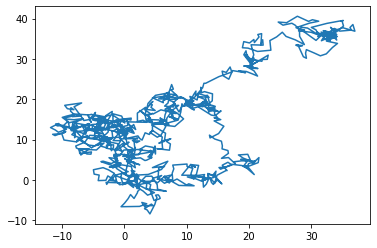

In [46]:
plt.plot(x, y)

In [60]:
theta = np.arctan(eigs[1]/eigs[0])
rotM = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [64]:
theta

0.21808752706690301

In [62]:
data = np.matmul(np.concatenate((x.reshape((-1, 1)), y.reshape((-1, 1))), axis=1), rotM)

In [65]:
data.shape

(1000, 2)

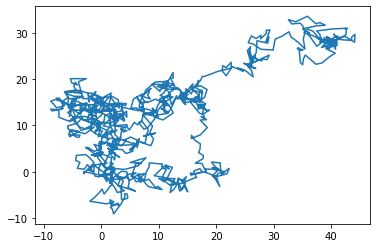

In [63]:
plt.plot(data[:, 0], data[:, 1])

I found an answer here:
https://stackoverflow.com/questions/13542855/algorithm-to-find-the-minimum-area-rectangle-for-given-points-in-order-to-comput

In [66]:
from scipy.ndimage.interpolation import rotate
from scipy.spatial import ConvexHull

In [90]:
def minBoundRect(x, y):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    
    points = np.concatenate((x.reshape((-1, 1)), y.reshape((-1, 1))), axis=1)
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    # Calculate the length of the sides of the min bound rect:
    xsq = np.diff(rval, axis=0)**2
    ls = np.sqrt(xsq[:, 0] + xsq[:, 1])
    
    return rval, ls[:2]

In [91]:
x, y = dt.walk2D()
rs, ls = minBoundRect(x, y)

In [204]:
def aspectRatio(x, y):
    rs, ls = minBoundRect(x, y)
    return np.max(ls)/np.min(ls), 1 - np.min(ls)/np.max(ls)

In [205]:
def aspectRatios(x, y):
    steps, N = x.shape
    ars = np.zeros(N)
    elongs = np.zeros(N)
    
    for i in range(N):
        ars[i], elongs[i] = aspectRatio(x[:, i], y[:, i])
        
    return ars, elongs

In [143]:
xs, ys = dt.walks2D(steps=100, N = 1000)
Ms, Gs = msds.trajsMSD(xs, ys)

In [154]:
x, y = dt.walk2D()
M, G = msds.trajMSD(x, y)

In [123]:
np.max(np.diff(x)**2 + np.diff(y)**2)/2

6.575443114196434

In [366]:
def bound(x, y, M):
    # I took dt out of the equation, as you both multiply and
    # divide by it, so it cancels out
    # boundedness
    N = M.shape[0]
    D = (M[1] - M[0])/(4)
    r = np.sqrt(np.max(np.diff(x)**2 + np.diff(y)**2))/2
    
    #trappedness
    bd = D*N/r**2
    return bd, 1 - np.exp(0.2048 - 0.25117*bd)

In [367]:
bound(x, y, M)

(111.71324111760704, 0.9999999999992001)

In [134]:
Ds = (Ms[1, :] - Ms[0, :])/4

(999, 10)

In [140]:
rs = np.max(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2, axis=0)/2

array([14.69363485, 11.94653087, 18.9578605 , 12.44474854, 14.71294892,
       15.95349015, 14.07785657, 12.75754416, 17.572223  , 13.25040102])

In [368]:
def bounds(xs, ys, Ms):
    # boundedness
    n, _ = Ms.shape
    Ds = (Ms[1, :] - Ms[0, :])/4
    rs = np.sqrt(np.max(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2, axis=0))/2
    
    #trappedness
    bds = Ds*n/rs**2
    return bds, 1 - np.exp(0.2048 - 0.25117*bds)

In [369]:
bs, ts = bounds(xs, ys, Ms)
noise = np.random.normal(size=1000)

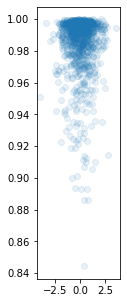

In [372]:
fig, ax = plt.subplots(figsize=(1.5, 5))
ax.scatter(noise, ts, alpha=0.1)


In [167]:
netD = (x[-1] - x[0])**2 + (y[-1] - y[0])**2

In [168]:
total = np.sum(np.diff(x)**2 + np.diff(y)**2)

In [169]:
netD/total

4.117725990658342

In [175]:
netD = (xs[-1, :] - xs[0, :])**2 + (ys[-1, :] - ys[0, :])**2
total = np.sum(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2, axis=0)

(1000,)

(1000,)

In [170]:
def efficiency(x, y):
    netD = (x[-1] - x[0])**2 + (y[-1] - y[0])**2
    total = np.sum(np.diff(x)**2 + np.diff(y)**2)
    return netD/total

In [178]:
def efficiencies(xs, ys):
    netD = (xs[-1, :] - xs[0, :])**2 + (ys[-1, :] - ys[0, :])**2
    total = np.sum(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2, axis=0)
    return netD/total

In [179]:
efs = efficiencies(xs, ys)

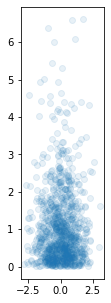

In [180]:
fig, ax = plt.subplots(figsize=(1.5, 5))
ax.scatter(noise, efs, alpha=0.1)

In [183]:
x = np.linspace(0, 10, 101)
y = np.zeros(101)

In [184]:
efficiency(x, y)

100.00000000000003

In [197]:
def straight(x, y):
    netD = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
    total = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    return netD/total

In [200]:
def straights(xs, ys):
    netD = np.sqrt((xs[-1, :] - xs[0, :])**2 + (ys[-1, :] - ys[0, :])**2)
    total = np.sum(np.sqrt(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2), axis=0)
    return netD/total

In [198]:
straight(x, y)

1.0

In [201]:
sts = straights(xs, ys)

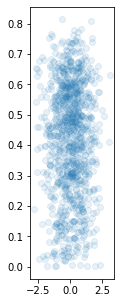

In [208]:
fig, ax = plt.subplots(figsize=(1.5, 5))
ax.scatter(noise, elongs, alpha=0.1)

In [206]:
ars, elongs = aspectRatios(xs, ys)

In [235]:
n = x.shape[0] - 1
total = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2)) # from straight
d = np.sqrt(np.max(np.diff(x)**2 + np.diff(y)**2)) # from bound

np.log(n)/np.log(n*n*d/total)

0.9999999999999969

In [249]:
def fractDim(x):
    n = x.shape[0] - 1
    total = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2)) # from straight
    d = np.sqrt(np.max(np.diff(x)**2 + np.diff(y)**2)) # from bound

    return np.log(n)/np.log(n*n*d/total)

In [259]:
x, y = dt.walk2D()
M, G = msds.trajMSD(x, y)

In [260]:
fractDim(x)

0.8508593498631336

In [253]:
xs.shape

(100, 1000)

In [264]:
n, _ = xs.shape
n = n - 1
total = np.sum(np.sqrt(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2)) # from straight
d = np.sqrt(np.max(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2, axis=0))

In [269]:
def fractDims(xs):
    n, _ = xs.shape
    n = n - 1
    total = np.sum(np.sqrt(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2), axis=0) # from straight
    d = np.sqrt(np.max(np.diff(xs, axis=0)**2 + np.diff(ys, axis=0)**2, axis=0)) # from bound

    return np.log(n)/np.log(n*n*d/total)

In [271]:
fds = fractDims(xs)

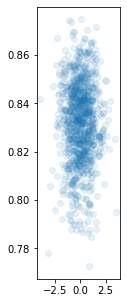

In [272]:
fig, ax = plt.subplots(figsize=(1.5, 5))
ax.scatter(noise, fds, alpha=0.1)

In [292]:
n = M.shape[0]
ns = np.linspace(1,n,n)

n2y, n2x = np.meshgrid(ns, ns)
M2y, M2x = np.meshgrid(M, M)

Mratio = M2x/M2y - n2x/n2y
Mratio[n2x > n2y] = 0

In [ ]:
def msdRatio(M):
    n = M.shape[0]
    ns = np.linspace(1,n,n)

    n2y, n2x = np.meshgrid(ns, ns)
    M2y, M2x = np.meshgrid(M, M)

    Mratio = M2x/M2y - n2x/n2y
    Mratio[n2x > n2y] = 0
    return MRatio

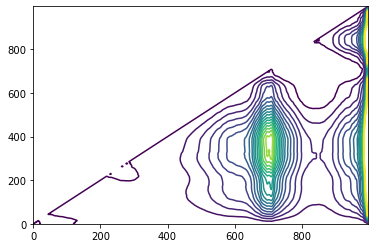

In [302]:
plt.contour(Mratio, levels=np.linspace(0, 8, 21))

In [356]:
def msdRatios(Ms):
    n, N = Ms.shape
    ns = np.linspace(1,n,n)


    n2y, n2x = np.meshgrid(ns, ns)
    n2y, n2x = np.tile(n2y.reshape((n,n,1)), (1,1,N)), np.tile(n2x.reshape((n,n,1)), (1,1,N))

    M2y, M2x = np.zeros((n,n,N)), np.zeros((n,n,N))
    for i in range(N):
        M2y[:,:,i], M2x[:,:,i] = np.meshgrid(Ms[:,i], Ms[:,i])

    Mratio = M2x/M2y - n2x/n2y
    Mratio[n2x > n2y] = 0
    return Mratio

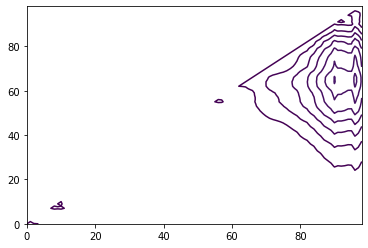

In [347]:
plt.contour(Mratio[:,:,20], levels=np.linspace(0, 8, 101))

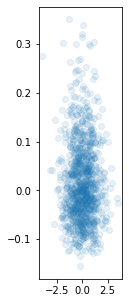

In [355]:
fig, ax = plt.subplots(figsize=(1.5, 5))
ax.scatter(noise, Mratio[5,10,:], alpha=0.1)

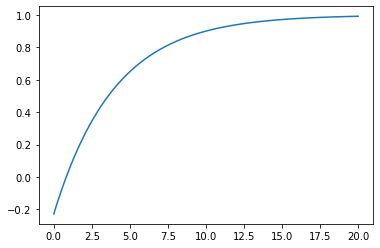

In [362]:
x1 = np.linspace(0, 20, 1001)
x2 = 1 - np.exp(0.2048 - 0.25117*x1)

plt.plot(x1, x2)
# Boundedness less than 1 results in a trappedness that is negative

In [401]:
a1, a2, a3, Ks = asyms(xs, ys)

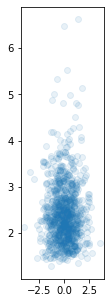

In [402]:
fig, ax = plt.subplots(figsize=(1.5, 5))
ax.scatter(noise, Ks, alpha=0.1)